In [ ]:
# !pip install -q --upgrade tensorflow_hub
# !pip install -q tensorflow_text
# !pip install -q tf-models-official
!conda install -y gdown

!gdown --id 1-2I0FAhkJih8jzRBWcG6JnxSFKIAwy3h
!gdown --id 1-CMbXaHcbAZy5J3EeuQFxFrzHFiPcuyk

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')

    print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
else:
    print("No GPU available.")

Physical GPUs: 1, Logical GPUs: 1


In [ ]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd
import tensorflow_text
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import *
from sklearn.metrics import *
from sklearn.model_selection import *

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# with open("/kaggle/working/train_data.pkl", 'rb') as f:
#     df = pickle.load(f)
df = pd.read_pickle('/kaggle/working/train_data.pkl')

In [ ]:
df.drop(['asin','reviewerName','helpful','summary','unixReviewTime','reviewTime','reviewerID'],inplace=True,axis=1)
df.head(10)

,reviewText,overall
411506,"Of course the music on this CD is great, but I...",4.0
611892,... releasing a similar collection of non-ozzy...,5.0
675972,"I first bought BODY LANGUAGE back in November,...",5.0
94908,I must admit I didn't like this album at first...,4.0
283470,I got this album because I liked these guys fl...,3.0
193907,"Thanks to the music fan from redding, CA and &...",2.0
968095,"Russian Circles is one of my favourite bands, ...",5.0
223710,Just after this album is prepared Ronnie Van Z...,4.0
142436,I would recommend this to serious Journey fans...,4.0
435887,Blondie is without a doubt one of the greatest...,5.0


In [ ]:
df['reviewText'] = df['reviewText'].str.lower()

In [ ]:
import string

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["reviewText"] = df["reviewText"].apply(lambda text: remove_punctuation(text))
df.head(5)

,reviewText,overall
411506,of course the music on this cd is great but i ...,4.0
611892,releasing a similar collection of nonozzy sab...,5.0
675972,i first bought body language back in november ...,5.0
94908,i must admit i didnt like this album at first ...,4.0
283470,i got this album because i liked these guys fl...,3.0


In [ ]:
X = df['reviewText']
y = df['overall']

y = pd.get_dummies(y,dtype=int)
y.head()

,1.0,2.0,3.0,4.0,5.0
411506,0,0,0,1,0
611892,0,0,0,0,1
675972,0,0,0,0,1
94908,0,0,0,1,0
283470,0,0,1,0,0


In [ ]:
# # Create a frequency table for the reviews
# review_counts = {}
# for review in df['overall']:
#   if review not in review_counts:
#     review_counts[review] = 0
#   review_counts[review] += 1

# # Create the heatmap
# plt.figure(figsize=(5, 3))
# plt.bar(review_counts.keys(), review_counts.values(), color='skyblue')
# plt.xlabel("Review Rating")
# plt.ylabel("Number of Reviews")
# plt.title("Distribution of Review Ratings")
# plt.show()

In [ ]:
preprocess_url ="https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
encoder_url =  "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2"

def build_model():
  #Input Layer
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  #preprocessing text to convert tokens using bert preprocessor
  preprocessing_layer = hub.KerasLayer(preprocess_url, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  #encoding recieved preprocess text to get self attention matrix
  encoder = hub.KerasLayer(encoder_url, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  layer = outputs['pooled_output']
  layer = Dropout(0.2)(layer)

  # layer = tf.keras.layers.Dense(512,activation='relu') (layer)
  # layer = Dropout(0.2)(layer)

  layer = tf.keras.layers.Dense(128,activation='relu') (layer)
  layer = Dropout(0.2)(layer)

  # layer = tf.keras.layers.Dense(16,activation='relu') (layer)
  # layer = Dropout(0.2)(layer)

  layer = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(layer)

  return tf.keras.Model(text_input, layer)

In [ ]:
model = build_model()

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2' to your Kaggle notebook...


In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=2e-5),
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit (X,y,
                     epochs = 3,
                     validation_split=0.2
                    )

Epoch 1/3


I0000 00:00:1707624055.736711   10113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20580/20580 [==============================] - 5417s 263ms/step - loss: 1.0737 - accuracy: 0.5831 - val_loss: 0.9703 - val_accuracy: 0.6095
Epoch 2/3
20580/20580 [==============================] - 5391s 262ms/step - loss: 1.0133 - accuracy: 0.6067 - val_loss: 0.9612 - val_accuracy: 0.6158
Epoch 3/3
20580/20580 [==============================] - 5377s 261ms/step - loss: 0.9981 - accuracy: 0.6095 - val_loss: 0.9567 - val_accuracy: 0.6171


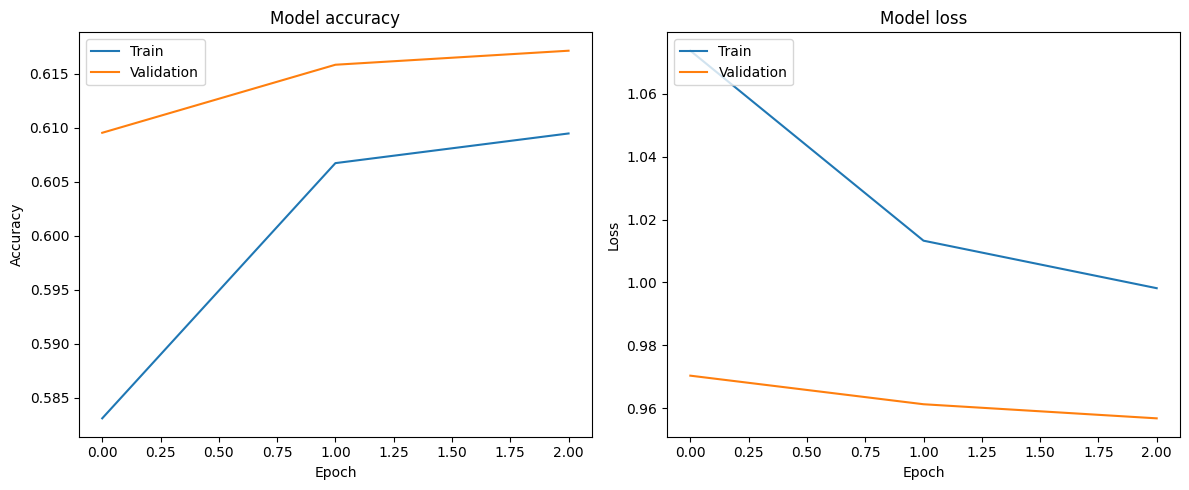

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# with open("/kaggle/working/test_data.pkl", 'rb') as f:
#     test = pickle.load(f)

test = pd.read_pickle('/kaggle/working/test_data.pkl')

test['reviewText'] = test['reviewText'].str.lower()

import string

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

test["reviewText"] = test["reviewText"].apply(lambda text: remove_punctuation(text))

X_test = test['reviewText']
y_test = test['overall']

In [ ]:
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1) + 1
print(classification_report(y_test,y_pred))

8575/8575 [==============================] - 1757s 205ms/step
              precision    recall  f1-score   support

         1.0       0.49      0.36      0.42     11549
         2.0       0.00      0.00      0.00     11643
         3.0       0.34      0.07      0.11     25456
         4.0       0.39      0.06      0.11     61581
         5.0       0.64      0.97      0.77    164169

    accuracy                           0.62    274398
   macro avg       0.37      0.29      0.28    274398
weighted avg       0.52      0.62      0.51    274398



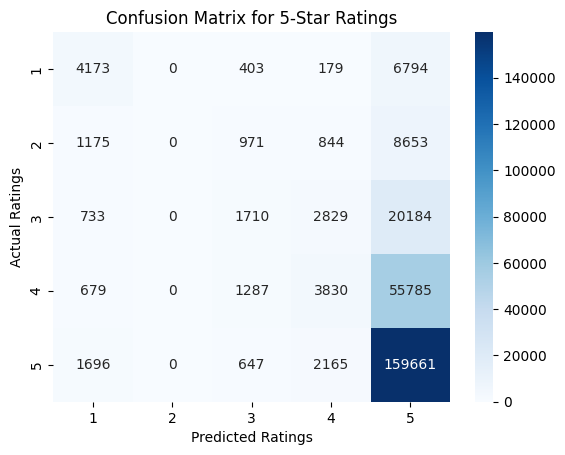

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Confusion Matrix for 5-Star Ratings')
plt.show()

In [ ]:
model.save('/kaggle/working/model_review_cd.h5')